In [1]:
import sys

sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata


from matplotlib.patches import Rectangle


def plot_hypercubes(ax, hypercubes: torch.Tensor, color="C0", alpha=0.4):
    for h in hypercubes:
        low, high = h[:, 0], h[:, 1]
        side_lengths = high - low

        patch = Rectangle(
            low, side_lengths[0], side_lengths[1], facecolor=color, alpha=alpha
        )
        ax.add_patch(patch)


def plot_as_heatmap(
    ax, x, y, z, n_points=1000, cmap="viridis", norm=None, interpolation="linear"
):
    x_min, x_max = min(x), max(x)
    y_min, y_max = min(y), max(y)
    X, Y = np.meshgrid(
        np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points)
    )
    Z = griddata((x, y), z, (X, Y), method=interpolation)
    pcm = ax.imshow(
        Z, extent=[x_min, x_max, y_min, y_max], origin="lower", cmap=cmap, norm=norm
    )
    return pcm

## Generating the dataset

In [2]:
# run pip install gymnasium[classic-control]
import gymnasium as gym

env = gym.make("Pendulum-v1", g=9.81)
env.action_space.seed(42)
observation, info = env.reset(seed=42)

XList = []
YList = []

target_size = 1

for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    XList.append(observation)
    YList.append(reward)

    if terminated or truncated:
        print("Ended with", _, "cycles")
        observation, info = env.reset()
env.close()

X = np.array(XList)
Y = np.array(YList)

print("Data", X)
print("Target", Y)
print(type(X), type(Y))
feature_size = X[0].size
print("feature_size", feature_size)

Ended with 199 cycles
Ended with 399 cycles
Ended with 599 cycles
Ended with 799 cycles
Ended with 999 cycles
Data [[-0.1878752   0.98219293  0.7695615 ]
 [-0.2587957   0.9659321   1.4555371 ]
 [-0.37170434  0.92835116  2.3813803 ]
 ...
 [-0.91808885 -0.39637464  1.8578407 ]
 [-0.87725824 -0.48001876  1.8622291 ]
 [-0.8421406  -0.539258    1.377593  ]]
Target [ -2.96562607  -3.15615964  -3.57223476  -4.37662138  -5.47108133
  -6.51930627  -8.24460812 -10.11882701 -12.16276136 -11.72831663
 -10.1038574   -8.48674183  -7.2141301   -5.90878147  -4.83416049
  -3.82632498  -3.04526135  -2.6021074   -2.38499988  -2.40976933
  -2.61769328  -2.98746467  -3.68597303  -4.4020848   -5.29923602
  -6.4120523   -8.05444331  -9.76145637 -11.90768142 -12.34838405
 -10.51995487  -8.72224077  -6.98767647  -5.75978364  -4.68733271
  -3.79794252  -3.18194895  -2.73085273  -2.41570586  -2.29927659
  -2.39670671  -2.71212984  -3.38384375  -4.35823125  -5.45236251
  -7.09942353  -9.06757075 -10.93663365 -12.

## Splitting the dataset intro train and test

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42
)
print(type(X_train), type(y_train))
print("X_train", X_train)
print("y_train", y_train)
print("X_test", X_test)
print("y_test", y_test)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
X_train [[-0.9153233   0.4027198  -5.551475  ]
 [-0.90790117 -0.41918427  4.973533  ]
 [-0.53026664 -0.84783095  5.2814984 ]
 ...
 [-0.97616833 -0.21701466  3.4849584 ]
 [-0.7841497  -0.6205717   1.2834414 ]
 [-0.47543857 -0.87974894 -3.1036816 ]]
y_train [-12.34838405 -11.54008515  -9.05271924  -7.29984497  -5.64897122
 -14.44613221  -9.41072393  -7.0283708   -8.26480701  -9.79746416
  -8.00906303  -6.5106909   -7.18578395  -8.92893087  -6.19991087
  -8.80253548  -2.36638244  -5.45818842  -5.94619214  -3.72513081
  -7.19106663 -10.89698006  -8.05591248 -11.86171961 -11.18887686
  -3.57223476  -2.8062585   -7.27251758  -5.32363275  -9.8125436
 -10.0157496  -10.04173866  -9.72853617 -11.83931011  -5.75978364
  -8.72224077  -6.31583505 -10.23882833  -4.65640443  -8.31102003
  -4.37662138  -7.80538339  -9.34040753  -3.97926629  -7.74881753
 -11.11708441 -10.37304477  -2.06055126  -5.27399089  -5.29420548
  -3.08409472  -7.87335002 -10.223444

## Learning with Context

In [4]:
from torch_mas.head import Head
from torch_mas.data import DataBuffer

model = Head(
    feature_size,
    target_size,
    R=0.25,
    imprecise_th=0.5,
    bad_th=0.0015,
    alpha=0.5,
    memory_length=3,
    n_epochs=5,
)

## Training the agents

In [5]:
import time

dataset = DataBuffer(X_train, y_train)
t = time.time()
model.fit(dataset)
tt = time.time() - t
print(f"Total training time: {tt}s")

print("Number of agents created:", model.agents.n_agents)

Total training time: 2.9267160892486572s
Number of agents created: 481


### Agents Visualization

Text(0, 0.5, 'Y')

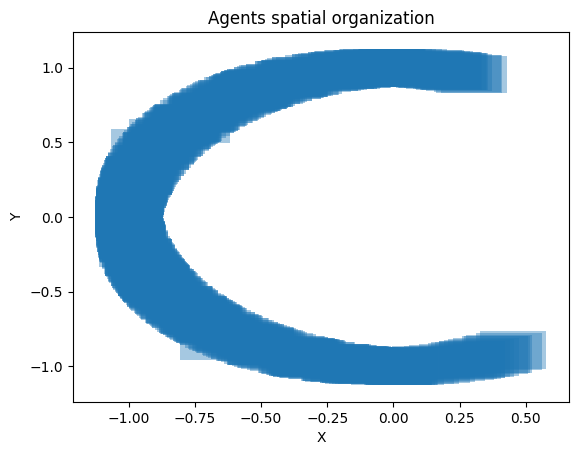

In [6]:
ax = plt.gca()
ax.scatter(dataset.X[:, 0], dataset.X[:, 1], marker="o", c="r", alpha=0)
plot_hypercubes(ax, model.agents.hypercubes.detach().numpy())
ax.set_title("Agents spatial organization")
ax.set_xlabel("X")
ax.set_ylabel("Y")

## Computing performance

In [7]:
print(type(X_test))

<class 'numpy.ndarray'>


Total Prediction time: 0.00780487060546875s for 4 samples
Prediction time per sample: 1.300811767578125e-05s
Mean Squared Error: nan
y_test tensor([ -4.8768,  -8.7894,  -5.4656,  -1.8090,  -9.8576,  -3.5414,  -5.9749,
         -7.7058, -10.1753,  -3.8081,  -8.0062,  -2.4895,  -4.2692,  -7.0121,
         -6.2550,  -7.7733,  -9.6169,  -5.9230,  -3.9103,  -7.3941,  -5.3582,
         -3.6630,  -7.5087,  -2.8831,  -8.5116,  -6.0086,  -3.5117,  -6.6840,
         -5.6812, -10.1724,  -9.0769,  -4.6295,  -1.6743,  -9.5454,  -7.2300,
         -9.0421,  -3.7921,  -1.1681,  -6.2358,  -2.4367,  -9.7937,  -3.2668,
         -8.9423,  -7.4147,  -6.8872,  -9.2914,  -6.8102,  -3.0766,  -5.9846,
         -6.0008,  -6.0011,  -9.9124,  -8.4962,  -6.5566,  -4.4021, -10.5200,
         -1.7113, -10.1039,  -7.6326,  -6.4218,  -9.0261,  -4.3692,  -3.4072,
         -9.2882,  -6.2609, -12.7925,  -1.6133,  -5.3173,  -9.1821,  -3.0354,
        -10.3932,  -6.1349,  -2.9602,  -4.7251,  -8.7290,  -6.0875, -11.2181,
  

Text(0.5, 1.0, 'Predictions on test')

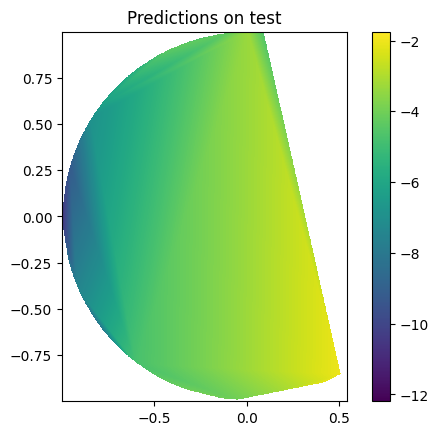

In [8]:
import time
import torch

test_feature_size = X_test.size
t = time.time()
y_pred = model.predict(torch.from_numpy(X_test).float())
y_test = torch.from_numpy(y_test)
tt = time.time() - t
tps = tt / test_feature_size
print(f"Total Prediction time: {tt}s for 4 samples")
print(f"Prediction time per sample: {tps}s")
mse = ((y_pred - y_test) ** 2).mean()
print("Mean Squared Error:", mse.detach().numpy())
print("y_test", y_test)
print("y_pred", y_pred.squeeze())

fig = plt.gcf()
ax = plt.gca()
pcm = plot_as_heatmap(
    ax,
    X_test[:, 0],
    X_test[:, 1],
    y_pred.detach().squeeze(),
    interpolation="linear",
    n_points=1000,
)
fig.colorbar(pcm)
ax.set_title("Predictions on test")